# SPECFEM Users Workshop -- Day 2 (Oct. 6, 2022)
## Day 2b: Kernel Exercise


- In this notebook we will have participants run their own adjoint simulation using Day 2a as a guide 
- We will use two homogeneous halfspace models for simplicity, building on the exercise from Day 1b  
- Adjoint simulations are key for performing seismic imaging (Day 3) as their results guide iterative model updates during the inverse problem  
- These instructions should be run from inside a Docker container, using Jupyter Lab (see instructions [here](https://github.com/adjtomo/adjdocs/blob/main/readmes/docker_image_install.md)).  
-----------

**Relevant Links:** 
- Today's Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_2b_kernels_exercise.ipynb
- Completed Notebook https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_2b_kernels_exercise.ipynb
- Day 0 Notebook (Container Testing): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_0_container_testing.ipynb
- Day 1A Notebook (Intro SPECFEM): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1a_intro_specfem2d.ipynb
- Day 1B Notebook (Fwd. Simulations): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1b_forward_simulations.ipynb
- Day 2A Notebook (Adj. Simulations): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_2a_kernels.ipynb

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.

-----------
## 0) Setting Up a SPECFEM2D Working Directory

- Let's set up a clean working directory to run SPECFEM2D  
- We will be doing all our work in the directory `/home/scoped/work/day_2/exercise`, all the following cells assume that we are in this directory  

In [1]:
# Python packages we might use in this notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# Make correct dir. and move there
! mkdir -p /home/scoped/work/day_2/exercise
%cd /home/scoped/work/day_2/exercise

# Symlink the executables and copy the relevant DATA/ directory
! ln -s /home/scoped/specfem2d/bin .
! cp -r /home/scoped/specfem2d/EXAMPLES/Tape2007/DATA .
! cp -f DATA/Par_file_Tape2007_onerec DATA/Par_file

# Ensure that SPECFEM outputs required files for adjoint simulations
! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1

! mkdir OUTPUT_FILES

! ls

/home/scoped/work/day_2/exercise
SAVE_MODEL: default -> binary
setup_with_binary_database: 0 -> 1
bin  DATA  OUTPUT_FILES


------------
## 1) Target Model Forward Simulations

- We'll use the **homogeneous halfspace** defined by default in the example as our target model
- Remember that the model spans X = [0, 480000]m and Z = [0, 480000]m  
- Also remember that there are 40 elements in X and Z, corresponding to element sizes of 12000m  

### 1a) STATIONS
- Using what you learned in Day 1, generate your own STATIONS file with an interesting configuration
- Look at *'STATIONS_checker'* to get a refresher of how the STATIONS file should be configured  
- *Remember* that eventually SPECFEM will be looking for a file called *'DATA/STATIONS'*

#### Choose your adventure:  
- **Easier approach**: Use the first 25 stations in the *'STATIONS_checker'* file  
- **Moderate approach**: Generate a horizontal or vertical line of 25 stations across your domain  
- **Advanced approach**: Use up to 100 stations to design an array configuration of your choice  
    - Potential configurations you could choose that might mimic a real world seismic array:  
        a) Cross shaped linear array  
        b) Uniform, dense gridded array  
        c) Spiral  
        d) Concentric rings  
        e) Dense linear array mimicing a DAS sensor  

Text(0.5, 1.0, 'Spiral Station Configuration')

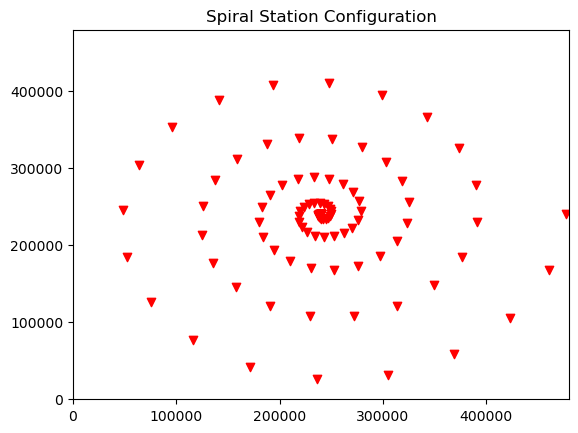

In [3]:
# Let's go for (c) Spiral
theta = np.radians(np.linspace(0, 360*5, 100))  # 100 stations  
c = 240  # scale factor for spread in stations
shift = c * 1E3  # shift spiral into required domain  
r = theta ** 2
x = (c * r * np.cos(theta)) + shift
z = (c * r * np.sin(theta)) + shift

plt.scatter(x, z, c="r", marker="v")  
plt.xlim([0, 480E3])
plt.ylim([0, 480E3])

plt.title("Spiral Station Configuration")

In [4]:
# Write out the coordinates to STATIONS file
with open("DATA/STATIONS", "w") as f:
    for i, (x_, z_) in enumerate(zip(x, z)):
        f.write(f"S{i:0>6} AA {x_:9.2f} {z_:9.2f} 0. 0.\n")

! head DATA/STATIONS

S000000 AA 240000.00 240000.00 0. 0.
S000001 AA 240022.96 240007.54 0. 0.
S000002 AA 240077.85 240057.32 0. 0.
S000003 AA 240126.17 240177.18 0. 0.
S000004 AA 240114.82 240369.25 0. 0.
S000005 AA 239990.41 240604.12 0. 0.
S000006 AA 239715.44 240822.20 0. 0.
S000007 AA 239282.82 240942.37 0. 0.
S000008 AA 238725.98 240877.10 0. 0.
S000009 AA 238121.69 240551.52 0. 0.


### 1b) SOURCE
- Let's create a SOURCE for our simulation
- *Remember* that SPECFEM2D is expecting a file called *'DATA/SOURCE'*  


#### Choose your adventure:  
- **Easier approach**: Use **one** of the available 25 *'SOURCE_???'* files located in the 'DATA' directory  
- **Moderate approach**: Use one of the available *'SOURCE_???'* files as a template, but change it's location to the center of the domain  
- **Advanced approach**: Can you think of an interesting moment tensor configuration for your source? Explosions are always fun! Can you place the SOURCE somewhere it would be interesting based on your station configuration? e.g.,  
    - at the center of a spiral or concentric rings  
    - normal to a linear array or grid  
    - at one end of a linear array

## Source 1
source_surf                     = .false.        # source inside the medium, or source automatically moved exactly at the surface by the solver
xs = 240000
zs = 240000
## Source type parameters:

Mxx = 1.0
Mzz = 1.0
Mxz = 1.0


Text(0.5, 1.0, 'Spiral Station Configuration')

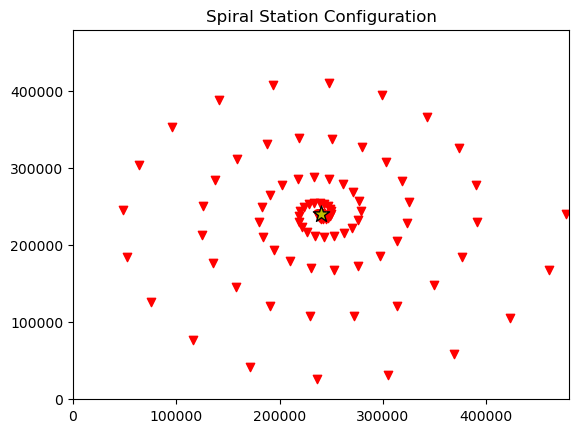

In [5]:
# Let's place the SOURCE at the center of the spiral, with explosive MT
! cp -f DATA/SOURCE_001 DATA/SOURCE

lines = open("DATA/SOURCE", "r").readlines()
for i, line in enumerate(lines):
    if "xs" in line:
        lines[i] = "xs = 240000\n"
    elif "zs" in line: 
        lines[i] = "zs = 240000\n"
    else:
        for value in ["Mxx", "Mzz", "Mxz"]:
            if value in line:
                lines[i] = f"{value} = 1.0\n"

# Write the SOURCE file changes
with open("DATA/SOURCE", "w") as f:
    f.writelines(lines)
    
# Check the file
! head -5 DATA/SOURCE
! echo
! head -51 DATA/SOURCE | tail -n 3

# Plot for reference
plt.scatter(x, z, c="r", marker="v")  
plt.scatter(240000, 240000, c="y", marker="*", edgecolor="k", s=150)
plt.xlim([0, 480E3])
plt.ylim([0, 480E3])

plt.title("Spiral Station Configuration")

### 1c) Run the Mesher and Solver  

1) *Remember* to tell SPECFEM to use your STATIONS file, and not it's internal definition of stations (see e.g., Day 2a, Section 2b)
2) Run your simulation in **parallel** using 4 cores  
    - *Remember* that you need to tell both SPECFEM and MPI that you are planning to run 4 processes  

The remainder of the `Par_file` should already be set up appropriately

In [6]:
! seisflows sempar -P DATA/Par_file use_existing_stations .true.
! seisflows sempar -P DATA/Par_file nproc 4

! mpirun -n 4 bin/xmeshfem2D > output_mesher.txt
! mpirun -n 4 bin/xspecfem2D > output_solver.txt

! tail output_solver.txt

use_existing_STATIONS: .false. -> .true.
NPROC: 1 -> 4
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Tape-Liu-Tromp (GJI 2007)
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 06 - 10 - 2022                                 T i m e  : 04:52:24
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


### 1d) Save Your Results
- Make sure you **save the seismograms** output by SPECFEM somewhere safe  
- *Remember* that subsequent simulations will **overwrite** files in the DATA/ and OUTPUT_FILES/ directory  
- Remember that displacement seismograms are stored in the *OUTPUT_FILES/* directory with the extension '*.semd*'

In [7]:
! mkdir target_synthetics
! mv OUTPUT_FILES/*semd target_synthetics
! ls target_synthetics

AA.S000000.BXY.semd  AA.S000034.BXY.semd  AA.S000068.BXY.semd
AA.S000001.BXY.semd  AA.S000035.BXY.semd  AA.S000069.BXY.semd
AA.S000002.BXY.semd  AA.S000036.BXY.semd  AA.S000070.BXY.semd
AA.S000003.BXY.semd  AA.S000037.BXY.semd  AA.S000071.BXY.semd
AA.S000004.BXY.semd  AA.S000038.BXY.semd  AA.S000072.BXY.semd
AA.S000005.BXY.semd  AA.S000039.BXY.semd  AA.S000073.BXY.semd
AA.S000006.BXY.semd  AA.S000040.BXY.semd  AA.S000074.BXY.semd
AA.S000007.BXY.semd  AA.S000041.BXY.semd  AA.S000075.BXY.semd
AA.S000008.BXY.semd  AA.S000042.BXY.semd  AA.S000076.BXY.semd
AA.S000009.BXY.semd  AA.S000043.BXY.semd  AA.S000077.BXY.semd
AA.S000010.BXY.semd  AA.S000044.BXY.semd  AA.S000078.BXY.semd
AA.S000011.BXY.semd  AA.S000045.BXY.semd  AA.S000079.BXY.semd
AA.S000012.BXY.semd  AA.S000046.BXY.semd  AA.S000080.BXY.semd
AA.S000013.BXY.semd  AA.S000047.BXY.semd  AA.S000081.BXY.semd
AA.S000014.BXY.semd  AA.S000048.BXY.semd  AA.S000082.BXY.semd
AA.S000015.BXY.semd  AA.S000049.BXY.semd  AA.S000083.BXY.semd
AA.S0000

------------
## 2) Initial Model Forward Simulations

- Let's edit the current model definition to create a separate initial or 'starting' model
- The starting model will also be a homogeneous halfspace, but with slightly different velocities 
- We'll use what we learned in the [Day 1B exercise](https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1b_forward_simulations.ipynb) to change the model parameters  

### 2a) Edit Velocity Model
- *Remember* that the velocity model is defined in the `Par_file`
- Let's **decrease** the velocity values (Vp and Vs) of the starting model by 20\%  
- In other words $V_p \rightarrow V_p - V_p \times 0.2$
- *Remember* from Day 1B that we can use SeisFlows to view and change the velocity model parameters, you can also use a text editor  

In [8]:
# Look at velocity model parameters
! seisflows sempar -P DATA/Par_file velocity_model

VELOCITY_MODEL:

1 1 2600.d0 5800.d0 3500.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0


In [9]:
vp = 5800.
vs = 3500.
vp_new = vp - vp * 0.2
vs_new = vs - vs * 0.2

print(f"vp: {vp} -> {vp_new}")
print(f"vs: {vs} -> {vs_new}")

vp: 5800.0 -> 4640.0
vs: 3500.0 -> 2800.0


In [10]:
! seisflows sempar -P DATA/Par_file velocity_model "1 1 2600.d0 3500.d0 2800.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0"

VELOCITY_MODEL:

1 1 2600.d0 5800.d0 3500.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0
->
1 1 2600.d0 3500.d0 2800.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0


### 2b) Set the `Par_file` for a new Forward Simulation

1) Tell SPECFEM to **save the forward wavefield** after the simulation  
2) Tell SPECFEM to **output binary database files** (as opposed to ASCII files)  
3) Tell SPECFEM to **save the model** in binary format

In [11]:
! seisflows sempar -P DATA/Par_file save_forward .true.
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1
! seisflows sempar -P DATA/Par_file save_model binary

SAVE_FORWARD: .false. -> .true.
setup_with_binary_database: 1 -> 1
SAVE_MODEL: binary -> binary


### 2c) Run the Mesher, Solver and Save Results  

1) Run your simulation in **parallel** using 4 cores
2) After your simulation, **save the seismograms** output by SPECFEM somewhere safe  

In [12]:
! mpirun -n 4 bin/xmeshfem2D > output_mesher.txt
! mpirun -n 4 bin/xspecfem2D > output_solver.txt

! tail output_solver.txt

 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Tape-Liu-Tromp (GJI 2007)
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 06 - 10 - 2022                                 T i m e  : 04:52:32
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


In [13]:
! mkdir initial_synthetics
! mv OUTPUT_FILES/*semd initial_synthetics
! ls initial_synthetics

AA.S000000.BXY.semd  AA.S000034.BXY.semd  AA.S000068.BXY.semd
AA.S000001.BXY.semd  AA.S000035.BXY.semd  AA.S000069.BXY.semd
AA.S000002.BXY.semd  AA.S000036.BXY.semd  AA.S000070.BXY.semd
AA.S000003.BXY.semd  AA.S000037.BXY.semd  AA.S000071.BXY.semd
AA.S000004.BXY.semd  AA.S000038.BXY.semd  AA.S000072.BXY.semd
AA.S000005.BXY.semd  AA.S000039.BXY.semd  AA.S000073.BXY.semd
AA.S000006.BXY.semd  AA.S000040.BXY.semd  AA.S000074.BXY.semd
AA.S000007.BXY.semd  AA.S000041.BXY.semd  AA.S000075.BXY.semd
AA.S000008.BXY.semd  AA.S000042.BXY.semd  AA.S000076.BXY.semd
AA.S000009.BXY.semd  AA.S000043.BXY.semd  AA.S000077.BXY.semd
AA.S000010.BXY.semd  AA.S000044.BXY.semd  AA.S000078.BXY.semd
AA.S000011.BXY.semd  AA.S000045.BXY.semd  AA.S000079.BXY.semd
AA.S000012.BXY.semd  AA.S000046.BXY.semd  AA.S000080.BXY.semd
AA.S000013.BXY.semd  AA.S000047.BXY.semd  AA.S000081.BXY.semd
AA.S000014.BXY.semd  AA.S000048.BXY.semd  AA.S000082.BXY.semd
AA.S000015.BXY.semd  AA.S000049.BXY.semd  AA.S000083.BXY.semd
AA.S0000

### 2d) Optional: Visualize Waveforms

- To make sure the two models were different, we can check our waveforms against one another  
- Use Python to plot matching seismograms against one another  
- Alternatively, you can use RecSec to plot *both* sets of synthetics, you'll need the following flags 
    - `--pysep_path`: path to tell RecSec where your 'data' is  
    - `--syn_path`: path to tell RecSec where your 'synthetics' are  
    - `--cmtsolution`: path to your 'SOURCE' file  
    - `--stations`: path to your 'STATIONS' file  
    - `--components`: the components of your seismograms. These are listed in the filenames (e.g., AA.S000099.BXY.semd is component 'Y')  
    - `--synsyn`: flag to tell RecSec that we are plotting two sets of synthetics (not actual data)  
    - `--cartesian`: flag to tell RecSec that our domain is cartesian (not geographic) 

[2022-10-06 04:52:34] - pysep - INFO: starting record section plotter
[2022-10-06 04:52:34] - pysep - INFO: Reading 100 synthetics from: initial_synthetics
[2022-10-06 04:52:34] - pysep - INFO: Reading 100 synthetics from: target_synthetics
[2022-10-06 04:52:35] - pysep - INFO: checking parameter acceptability
[2022-10-06 04:52:35] - pysep - INFO: getting source-receiver stats
[2022-10-06 04:52:35] - pysep - INFO: calculating source-receiver distance and (back)azimuths
[2022-10-06 04:52:35] - pysep - INFO: preprocessing 100 `st` waveforms
[2022-10-06 04:52:35] - pysep - INFO: no filtering applied
[2022-10-06 04:52:35] - pysep - INFO: determining sort order with parameter: distance
[2022-10-06 04:52:35] - pysep - INFO: determining if any stations/channels should be skipped
[2022-10-06 04:52:35] - pysep - INFO: criteria check will remove 0/100 traces
[2022-10-06 04:52:35] - pysep - INFO: determining y-axis positioning for sort: distance
[2022-10-06 04:52:35] - pysep - INFO: determining a

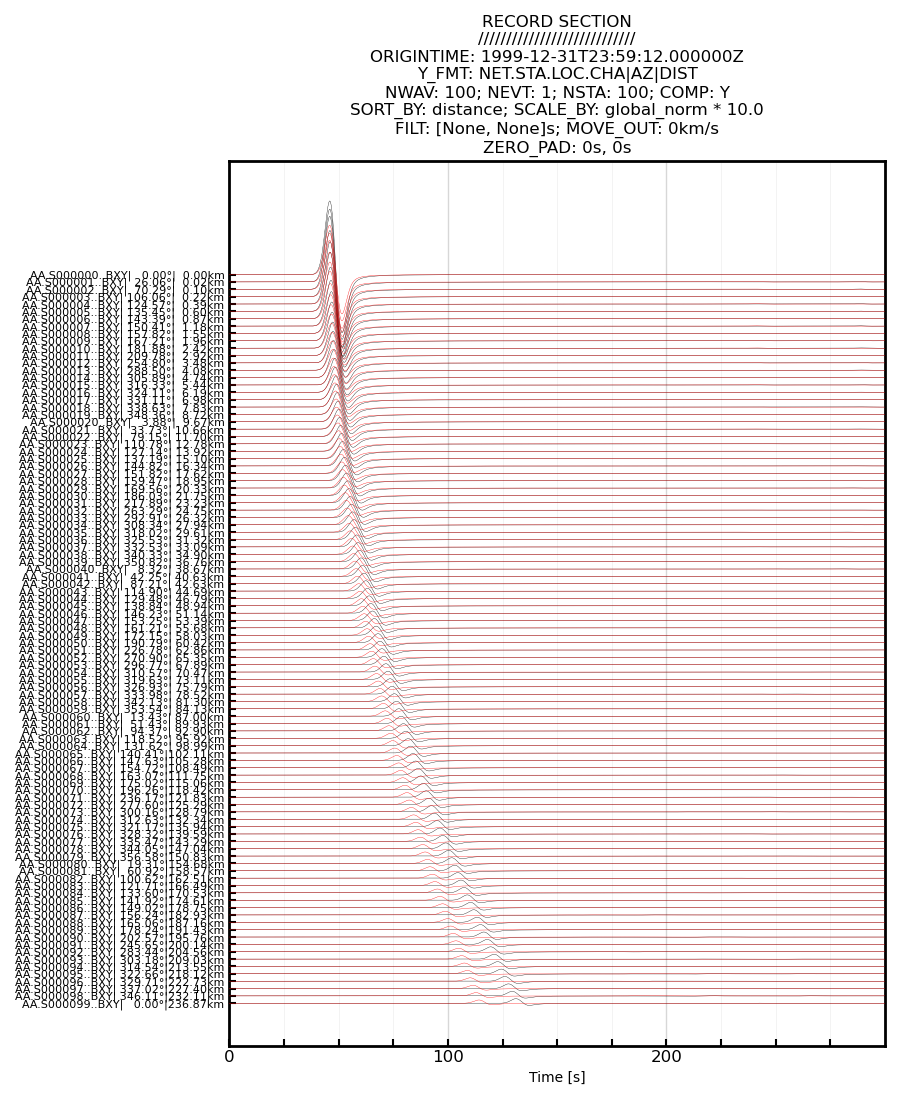

In [14]:
# Plotting with RecSec and a few additional (bonus!) parameters
! recsec --pysep_path initial_synthetics --syn_path target_synthetics --cmtsolution 'DATA/SOURCE' --stations 'DATA/STATIONS' \
    --scale_by global_norm --amplitude_scale_factor 10 --components XY --synsyn --cartesian -L INFO -o

Image("record_section.png")

---------------
## 3) Quantify Misfit, Generate Adjoint Sources

- You should now have **two sets of synthetics**, one generated by your initial model, another by your target model
- We now want to generate adjoint sources for each pair of synthetics

#### Choose your adventure:  
- **Easier/Moderate approach**: Define a waveform difference misfit function as in Day 2a, Section 3b  
- **Advanced approach**: Head to Section 3B to try and define a cross-correlation traveltime misfit function    

### 3a_1) Easier/Moderate Approach: Waveform Misfit

- Waveform misfit adjoint source: $f^\dagger (t) = s(t) - d(t)$  
- You can use the following as a template for defining your waveform misfit function

---------
Start with the following template and try to follow steps above:
```python
from scipy.integrate import simps


def waveform_misfit(d, s):
    """
    Define a waveform misft adjoint source
    
    :type d: np.array
    :param d: data array
    :type s: np.array
    :param s: synthetic array
    :rtype adj_src: np.array
    :return adj_src: adjoint source array
    """
    # follow steps 1-5 here
    # ...
    return adj_src
```

In [15]:
from scipy.integrate import simps


def waveform_misfit(d, s):
    """
    Define a waveform misft adjoint source
    
    :type d: np.array
    :param d: data array
    :type s: np.array
    :param s: synthetic array
    :rtype adj_src: np.array
    :return adj_src: adjoint source array
    """
    adj_src = s - d

    return adj_src

--------------------
### 3a_2) Advanced Approach: Define a Cross-Correlation Traveltime Misfit Function

- Let's use a cross correlation traveltime misfit function to define our adjoint source  
- The cross correlation misfit is defined: $\chi (\mathbf{m}) = \frac{1}{2} \left[ T^{obs} - T(\mathbf{m}) \right] ^ 2$,  
- Where $T^{obs}$ is the observed traveltime, and $T(\mathbf{m})$ is the
predicted traveltime in Earth model $m$  
- **Alternatively**, you can use the waveform difference objective function we say in Day 2 Section 3A  

>__Adjoint Source Equation:__ $f^{\dagger}(t) = - \left[ T^{obs} - T(\mathbf{m}) \right] ~ \frac{1}{N} ~
    \partial_t \mathbf{s}(T - t, \mathbf{m})$
       
Complete the function below using the following steps:

1) Calculate the time shift $\left[ T^{obs} - T(\mathbf{m})\right]$ using [ObsPy's cross correlation function](https://docs.obspy.org/master/packages/autogen/obspy.signal.cross_correlation.correlate.html) 
    - The correlate function returns an array of correlation values
    - Use [xcorr_max](https://docs.obspy.org/master/packages/autogen/obspy.signal.cross_correlation.xcorr_max.html#obspy.signal.cross_correlation.xcorr_max) to find the time shift related to the peak cross correlation
    - The time shift should be a **single value**
2) Differentiate the synthetic waveform, $\partial_t \mathbf{s}(t, \mathbf{m})$,  using [NumPy gradient](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html)  
3) Set the normalization factor $N$ as:  $N = \int_0^T ~ \mathbf{s}(t, \mathbf{m}) ~ \partial^2_t \mathbf{s}(t, \mathbf{m}) dt$  
    - Where T is the total seismogram time
    - Use [SciPy's Simpson's rule](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.simps.html) to integrate  
4) Time reverse the differentiated synthetic waveform $\partial_t \mathbf{s}(T - t, \mathbf{m})$  
5) Return an adjoint source that combines parts 1 through 4 that follows the **Adjoint Source Equation** above. Remember the -1!


---------
Start with the following template and try to follow steps above:
```python
from numpy import gradient
from scipy.integrate import simps
from obspy.signal.cross_correlation import correlate, xcorr_max


def cc_traveltime_adjsrc(d, s):
    """
    Define a cross-correlation traveltime adjoint source
    
    :type d: np.array
    :param d: data array
    :type s: np.array
    :param s: synthetic array
    :rtype adj_src: np.array
    :return adj_src: adjoint source array
    """
    # follow steps 1-5 here
    # ...
    return adj_src
```

In [16]:
from numpy import gradient
from scipy.integrate import simps
from obspy.signal.cross_correlation import correlate, xcorr_max

def cc_traveltime_adjsrc(d, s):
    """
    Define a cross-correlation traveltime adjoint source
    
    :type d: np.array
    :param d: data array
    :type s: np.array
    :param s: synthetic array
    :rtype adj_src: np.array
    :return adj_src: adjoint source array
    """
    # Step 1: calculate time shift
    cc = correlate(d, s, shift=100)
    tshift, value = xcorr_max(cc)
    
    # Step 2: differentiate synthetic
    ds = gradient(s)
    
    # Step 3: Set normalization factor
    norm = simps(s * (ds **2))
    
    # Step 4: time-reverse differentiated synthetic
    ds = ds[::-1]
    
    # Step 5: Multiply by -1
    minus_one = -1
    
    # Step 6: Define adj src
    adj_src = -1 * tshift / norm * ds
    
    return adj_src

### 3b) Generate Adjoint Sources

1) **Loop** through all available data and synthetic seismogram files, make sure filenames match!  
1) **Load** in data and synthetic seismogram for a single station (use `numpy.loadtxt`; see Day 2A; Section 2C)
2) **Apply** your adjoint source function from 3A to **output** an adjoint source array  
3) **Save** the corresponding adjoint source in the `SEM/` directory (using `numpy.savetxt`; see Day 2A; Section 3A)
    - *Remember* to format the adjoint source the same as the input synthetics
    - *Remember* that adjoint sources must mimic the synthetic filename, but end with *.adj*
    
*Feel free to import Python modules required to file match and loop!*  

In [17]:
import os
from glob import glob

# Make sure SEM directory exists
! rm -r SEM/
! mkdir SEM/

# Step 1: Loop through data
for path_initial in glob("initial_synthetics/*.semd"):
    # Making sure filenames match
    fid = os.path.basename(path_initial)
    path_target = f"target_synthetics/{fid}"
    
    # Step 2: Load in data using numpy loadtxt
    t_init, d_init = np.loadtxt(path_initial).T
    t_trgt, d_trgt = np.loadtxt(path_target).T
    
    # Step 3: Apply adjoint source function
    d_adjsrc = cc_traveltime_adjsrc(d=d_init, s=d_trgt)
    
    # Step 4: Write adjoint sources
    adj_src = np.vstack((t_init, d_adjsrc)).T
    np.savetxt(f"SEM/{fid.replace('.semd', '.adj')}", adj_src)

! ls SEM/
! echo
! head SEM/AA.S000000.BXY.adj

rm: cannot remove 'SEM/': No such file or directory
AA.S000000.BXY.adj  AA.S000025.BXY.adj	AA.S000050.BXY.adj  AA.S000075.BXY.adj
AA.S000001.BXY.adj  AA.S000026.BXY.adj	AA.S000051.BXY.adj  AA.S000076.BXY.adj
AA.S000002.BXY.adj  AA.S000027.BXY.adj	AA.S000052.BXY.adj  AA.S000077.BXY.adj
AA.S000003.BXY.adj  AA.S000028.BXY.adj	AA.S000053.BXY.adj  AA.S000078.BXY.adj
AA.S000004.BXY.adj  AA.S000029.BXY.adj	AA.S000054.BXY.adj  AA.S000079.BXY.adj
AA.S000005.BXY.adj  AA.S000030.BXY.adj	AA.S000055.BXY.adj  AA.S000080.BXY.adj
AA.S000006.BXY.adj  AA.S000031.BXY.adj	AA.S000056.BXY.adj  AA.S000081.BXY.adj
AA.S000007.BXY.adj  AA.S000032.BXY.adj	AA.S000057.BXY.adj  AA.S000082.BXY.adj
AA.S000008.BXY.adj  AA.S000033.BXY.adj	AA.S000058.BXY.adj  AA.S000083.BXY.adj
AA.S000009.BXY.adj  AA.S000034.BXY.adj	AA.S000059.BXY.adj  AA.S000084.BXY.adj
AA.S000010.BXY.adj  AA.S000035.BXY.adj	AA.S000060.BXY.adj  AA.S000085.BXY.adj
AA.S000011.BXY.adj  AA.S000036.BXY.adj	AA.S000061.BXY.adj  AA.S000086.BXY.adj
AA.S000012.B

## 3c) Optional: Plot an adjoint source

- It's always useful to look at adjoint sources before running an adjoint simulation  
- Plot **one** adjoint source next to its corresponding data and synthetic waveforms if you can  
- We should be able to immediately tell if the adjoint source looks appropriate  
- *Remember* that we plotted adjoint sources in Day 2a Section 3b

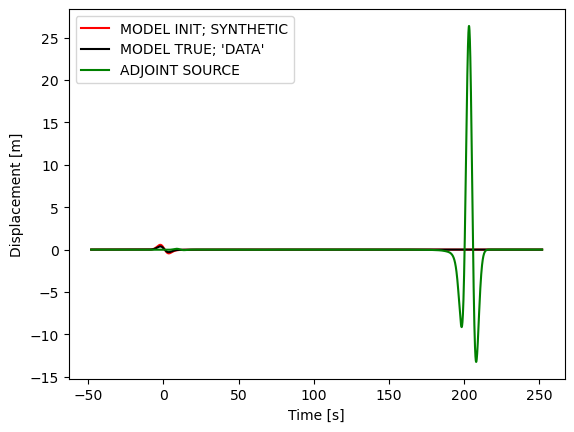

In [18]:
t_init, d_init = np.loadtxt("initial_synthetics/AA.S000000.BXY.semd").T
t_true, d_true = np.loadtxt("target_synthetics/AA.S000000.BXY.semd").T
t_adj, d_adj = np.loadtxt("SEM/AA.S000000.BXY.adj").T

# Plot both waveforms using Matplotlib
plt.plot(t_init, d_init, c="r", label="MODEL INIT; SYNTHETIC")
plt.plot(t_true, d_true, c="k", label="MODEL TRUE; 'DATA'")
plt.plot(t_init, d_adj, c="g", label="ADJOINT SOURCE")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.legend()
plt.show()

------------
## 4) Run Adjoint Simulations

- *Remember* to tell SPECFEM that this is an adjoint simulation (not a forward simulation)
- *Remember* to tell SPECFEM to **output** kernel files in FORTRAN Binary format
- Make sure that your adjoint sources are stored in the `SEM/` directory (Step 3)  
- Make sure your DATABASE files are available in the *OUTPUT_FILES/* directory (Step 2)  
- Remember you do **not** need to run the mesher, only the solver  
- Check the output log file and kernel files to make sure you ran an adjoint simulation (not forward)

In [19]:
! seisflows sempar -P DATA/Par_file simulation_type 3
! seisflows sempar -P DATA/Par_file save_ASCII_kernels .false.

! mpirun -n 4 bin/xspecfem2D > adjoint_solver.txt

# Check that we've created the kernel files
! tail adjoint_solver.txt
! ls OUTPUT_FILES/*.bin

SIMULATION_TYPE: 1 -> 3
save_ASCII_kernels: .true. -> .false.
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Tape-Liu-Tromp (GJI 2007)
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 06 - 10 - 2022                                 T i m e  : 04:52:45
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
OUTPUT_FILES/absorb_elastic_bottom000002.bin
OUTPUT_FILES/absorb_elastic_bottom000003.bin
OUTPUT_FILES/absorb_elastic_left000001.bin
OUTPUT_FILES/absorb_elastic_left000003.bin
OUTPUT_FILES/absorb_elastic_right000000.bin
OUTPUT_FILES/absorb_elast

## 5) Smooth Kernel
- **Smooth** your Vp and Vs kernels by 10km in the horizontal direction and 10 km in the vertical
- Make sure that SPECFEM can find the appropriate files (kernels, database and model files are all locatable in the same directory)  
- Look at Day 2A Section 4 if you need help calling the smoothing executable  
- Remember to run the smoother with 4 MPI processors  

In [20]:
# Smooth the Vp and Vs kernels
! cp DATA/*bin OUTPUT_FILES

! mpirun -n 4 bin/xsmooth_sem 10000 10000 alpha_kernel OUTPUT_FILES/ OUTPUT_FILES/ .false.
! mpirun -n 4 bin/xsmooth_sem 10000 10000 beta_kernel OUTPUT_FILES/ OUTPUT_FILES/ .false.

 Running XSMOOTH_SEM on           4 processors
 command line arguments:
   smoothing sigma_h , sigma_v                :    10000.0000       10000.0000    
   smoothing scalelengths horizontal, vertical:    28284.2715       28284.2715    
   input dir : OUTPUT_FILES/
   output dir: OUTPUT_FILES/


 Scaling values: min/max =    157079632.       628318848.    
 written: OUTPUT_FILES//proc000000_alpha_kernel_smooth.bin

  Min / Max data value before smoothing =    0.00000000       0.00000000     for alpha_kernel
  Min / Max data value after smoothing  =    0.00000000       0.00000000     for alpha_kernel
 Computation time with CPU:   1.29205132    
 Computation time with CPU:   1.29205310    
 Computation time with CPU:   1.29205322    
 Computation time with CPU:   1.29205024    
 Running XSMOOTH_SEM on           4 processors
 command line arguments:
   smoothing sigma_h , sigma_v                :    10000.0000       10000.0000    
   smoothing scalelengths horizontal, vertical:    28284.

-------------
## 6) Visualize Results
- Use SeisFlows (see Day 2a, Section 4) or NumPy + Matplotlib to visualize your kernel results  
- Does your kernel make sense?
- Can you plot the sources and stations on top of the kernel figure?
- **NOTE:** If you use SeisFlows, you'll need to import the Model tool and change the names of the kernels from 'alpha' -> 'vp' and 'beta' -> 'vs'

```python 
from seisflows.tools.specfem import Model
# OR
from seisflows.tools.specfem import read_fortran_binary
```

In [21]:
# Manually do this for convenience
! mkdir KERNEL 

! cp -r DATA/*bin KERNEL

! mv OUTPUT_FILES/proc000000_alpha_kernel_smooth.bin KERNEL/proc000000_vp_kernel.bin
! mv OUTPUT_FILES/proc000001_alpha_kernel_smooth.bin KERNEL/proc000001_vp_kernel.bin
! mv OUTPUT_FILES/proc000002_alpha_kernel_smooth.bin KERNEL/proc000002_vp_kernel.bin
! mv OUTPUT_FILES/proc000003_alpha_kernel_smooth.bin KERNEL/proc000003_vp_kernel.bin

! mv OUTPUT_FILES/proc000000_beta_kernel_smooth.bin KERNEL/proc000000_vs_kernel.bin
! mv OUTPUT_FILES/proc000001_beta_kernel_smooth.bin KERNEL/proc000001_vs_kernel.bin
! mv OUTPUT_FILES/proc000002_beta_kernel_smooth.bin KERNEL/proc000002_vs_kernel.bin
! mv OUTPUT_FILES/proc000003_beta_kernel_smooth.bin KERNEL/proc000003_vs_kernel.bin

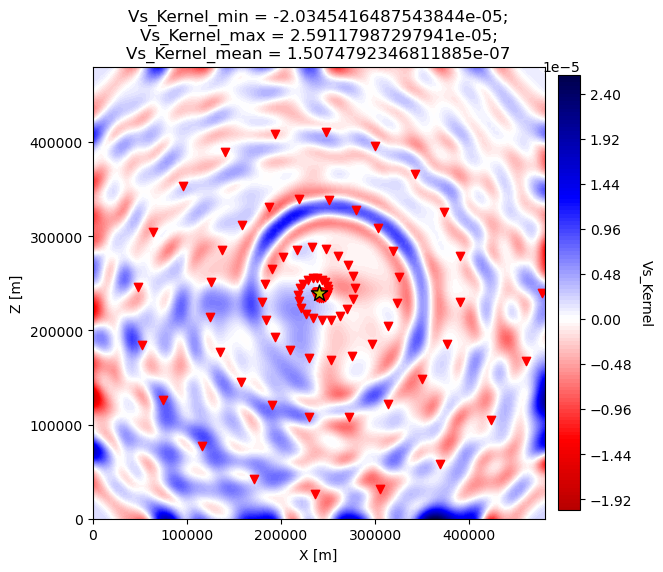

In [22]:
from seisflows.tools.specfem import Model

m = Model("KERNEL", fmt=".bin")
m.plot2d("vs_kernel", show=False)
plt.scatter(x, z, c="r", marker="v")  
plt.scatter(240000, 240000, c="y", marker="*", edgecolor="k", s=150)
plt.show()